# **Stop Detection Performancea and Benchmarking**

## Load data 

In [1]:
%matplotlib inline
import nomad.io.base as loader
import geopandas as gpd
from shapely.geometry import Polygon, box, Point
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import shapely.plotting as shp_plt
from IPython.display import HTML
from nomad.stop_detection.viz import adjust_zoom, plot_stops_barcode, plot_pings, plot_stops, plot_time_barcode
import nomad.stop_detection.dbscan as DBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.grid_based as GRID_BASED
import nomad.filters as filters 

city = gpd.read_file("garden_city.geojson").to_crs('EPSG:3857')
outer_box = box(*city.total_bounds).buffer(15, join_style='mitre')

filepath_root = '../tutorials/IC2S2-2025/gc_data_long/'
tc = {
    "user_id": "gc_identifier",
    "timestamp": "unix_ts",
    "x": "dev_x",
    "y": "dev_y",
    "ha":"ha",
    "date":"date"}

users = ['admiring_brattain']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters = ('date','==', '2024-01-01'), traj_cols=tc)

## Stop detection algorithms

In [5]:
import nomad.stop_detection.dbscan as DBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.grid_based as GRID_BASED
import nomad.filters as filters 
import nomad.stop_detection.postprocessing as post
import time

### Lachesis (sequential stop detection)

In [ ]:
start_time = time.time()
stops = LACHESIS.lachesis(traj, delta_roam=20, dt_max = 60, dur_min=5, complete_output=True, keep_col_names=True, traj_cols=tc)
execution_time_lachesis = time.time() - start_time
print(f"Lachesis execution time: {execution_time_lachesis} seconds")

Lachesis execution time: 0.2639038562774658 seconds


### Density based stop detection (Temporal DBSCAN)

In [33]:
start_time_pre_tadbscan = time.time()
users = ['confident_aryabhata']
traj = loader.sample_from_file(filepath_root, format='parquet', users=users, filters = ('date','<=', '2024-01-03'), traj_cols=tc)
traj[['longitude','latitude']] = np.column_stack(
    filters.to_projection(traj, x='dev_x', y='dev_y', data_crs='EPSG:3857', crs_to='EPSG:4326')
)
time_pre_tadbscan = time.time() - start_time_pre_tadbscan

In [34]:
start_time = time.time()
user_data_tadb = traj.assign(cluster=DBSCAN.ta_dbscan_labels(traj, time_thresh=240, dist_thresh=15, min_pts=3, traj_cols=tc))
clustering_time_tadbscan = time.time() - start_time
start_time_post = time.time()
stops_tadb = post.remove_overlaps(user_data_tadb, time_thresh=240, method='cluster', traj_cols=tc, min_pts=3, dur_min=5, min_cluster_size=3)
execution_time_tadbscan = time.time() - start_time
post_time_tadbscan = time.time() - start_time_post
print(f"TA-DBSCAN execution time: {execution_time_tadbscan} seconds")
print(f"TA-DBSCAN pre-processing time: {time_pre_tadbscan} seconds")
print(f"TA-DBSCAN clustering time: {clustering_time_tadbscan} seconds")
print(f"TA-DBSCAN post-processing time: {post_time_tadbscan} seconds")

TA-DBSCAN execution time: 0.22460603713989258 seconds
TA-DBSCAN pre-processing time: 0.3470630645751953 seconds
TA-DBSCAN clustering time: 0.16065311431884766 seconds
TA-DBSCAN post-processing time: 0.06392097473144531 seconds


/Users/carolinechen/Desktop/cs/nomad/nomad/io/base.py:104: UserWarning: Trajectory column 'cluster' specified for 'location_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/carolinechen/Desktop/cs/nomad/nomad/io/base.py:104: UserWarning: Trajectory column 'cluster' specified for 'location_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/carolinechen/Desktop/cs/nomad/nomad/io/base.py:104: UserWarning: Trajectory column 'cluster' specified for 'location_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/carolinechen/Desktop/cs/nomad/nomad/io/base.py:104: UserWarning: Trajectory column 'cluster' specified for 'location_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/carolinec

## Grid-Based

In [10]:
start_time = time.time()
traj['h3_cell'] = filters.to_tessellation(traj, index="h3", res=10, x='dev_x', y='dev_y', data_crs='EPSG:3857')
stops_gb = GRID_BASED.grid_based(traj, time_thresh=240, complete_output=True, timestamp='unix_ts', location_id='h3_cell')
execution_time_grid = time.time() - start_time
print(f"Grid-Based execution time: {execution_time_grid} seconds")

Grid-Based execution time: 0.3693399429321289 seconds


## HDBSCAN

In [29]:
import nomad.stop_detection.hdbscan as HDBSCAN
start_time = time.time()
user_data_hdb = traj.assign(cluster=HDBSCAN.hdbscan_labels(traj, time_thresh=240, min_pts=3, min_cluster_size=2, traj_cols=tc))
clustering_time_hdbscan = time.time() - start_time
start_time_post = time.time()
stops_hdb = post.remove_overlaps(user_data_hdb, time_thresh=240, method='cluster', traj_cols=tc, min_pts=3, dur_min=5, min_cluster_size=3)    
execution_time_hdbscan = time.time() - start_time
post_time_hdbscan = time.time() - start_time_post
print(f"HDBSCAN execution time: {execution_time_hdbscan} seconds")
print(f"HDBSCAN clustering time: {clustering_time_hdbscan} seconds")
print(f"HDBSCAN post-processing time: {post_time_hdbscan} seconds")

HDBSCAN execution time: 3.0082061290740967 seconds
HDBSCAN clustering time: 2.9648900032043457 seconds
HDBSCAN post-processing time: 0.043320655822753906 seconds


/Users/carolinechen/Desktop/cs/nomad/nomad/io/base.py:104: UserWarning: Trajectory column 'cluster' specified for 'location_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/carolinechen/Desktop/cs/nomad/nomad/io/base.py:104: UserWarning: Trajectory column 'cluster' specified for 'location_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/carolinechen/Desktop/cs/nomad/nomad/io/base.py:104: UserWarning: Trajectory column 'cluster' specified for 'location_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/carolinechen/Desktop/cs/nomad/nomad/io/base.py:104: UserWarning: Trajectory column 'cluster' specified for 'location_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/carolinec

## Summary of Single-User Performance

### Lachesis

C:\Users\pacob\Documents\repositories\nomad-repo\nomad\io\base.py:107: UserWarning: Trajectory column 'x' specified for 'x' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
C:\Users\pacob\Documents\repositories\nomad-repo\nomad\io\base.py:107: UserWarning: Trajectory column 'y' specified for 'y' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")


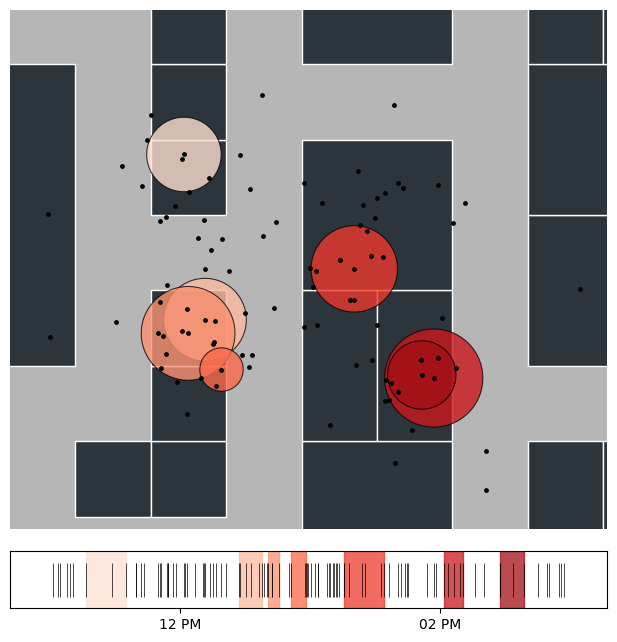

In [ ]:
fig, (ax_map, ax_barcode) = plt.subplots(2, 1, figsize=(6,6.5),
                                         gridspec_kw={'height_ratios':[10,1]})

shp_plt.plot_polygon(outer_box, ax=ax_map, add_points=False, color='#0e0e0e')
city.plot(ax=ax_map, edgecolor='white', linewidth=1, color='#2c353c')

plot_stops(stops, ax=ax_map, cmap='Reds', x='dev_x', y='dev_y')
plot_pings(traj, ax=ax_map, s=6, point_color='black', cmap='twilight', traj_cols=tc)

adjust_zoom(stops['dev_x'], stops['dev_y'], buffer=1.4, ax=ax_map)
ax_map.set_axis_off()

plot_time_barcode(traj[tc['timestamp']], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops, ax=ax_barcode, cmap='Reds', set_xlim=False, x='x', y='y', timestamp='unix_ts')

plt.tight_layout(pad=0.1)
plt.show()

### TADBSCAN

/Users/carolinechen/Desktop/cs/nomad/nomad/io/base.py:104: UserWarning: Trajectory column 'unix_ts' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")


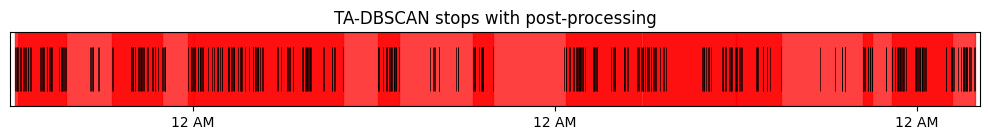

In [20]:
fig, ax_barcode = plt.subplots(figsize=(10,1.5))

plot_time_barcode(traj['unix_ts'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops_tadb, ax=ax_barcode, stop_color='red', set_xlim=False, timestamp='unix_ts')
plt.title("TA-DBSCAN stops with post-processing")
plt.tight_layout()
plt.show()

### Grid-Based

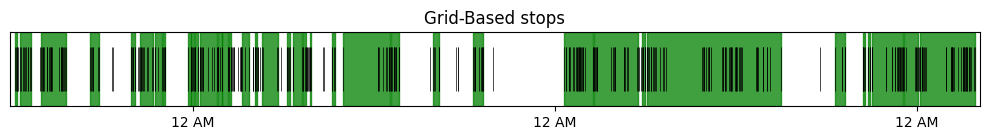

In [21]:
fig, ax_barcode = plt.subplots(figsize=(10,1.5))

plot_time_barcode(traj['unix_ts'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops_gb, ax=ax_barcode, stop_color='green', set_xlim=False, timestamp='unix_ts')
plt.title("Grid-Based stops")
plt.tight_layout()
plt.show()

### HDBSCAN

/Users/carolinechen/Desktop/cs/nomad/nomad/io/base.py:104: UserWarning: Trajectory column 'unix_ts' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")


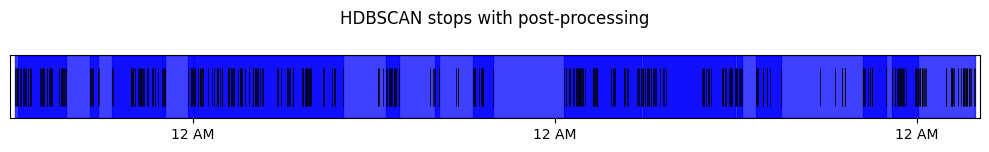

In [22]:
fig, ax_barcode = plt.subplots(figsize=(10,1.5))

plot_time_barcode(traj['unix_ts'], ax=ax_barcode, set_xlim=True)
plot_stops_barcode(stops_hdb, ax=ax_barcode, stop_color='blue', set_xlim=False, timestamp='unix_ts')
fig.suptitle("HDBSCAN stops with post-processing")
plt.tight_layout()
plt.show()

In [35]:
print("Summary of Single-User Performance")
print(f"Lachesis execution time: {execution_time_lachesis} seconds")
print(f"TA-DBSCAN execution time: {execution_time_tadbscan} seconds")
print(f"Grid-Based execution time: {execution_time_grid} seconds")
print(f"HDBSCAN execution time: {execution_time_hdbscan} seconds")

Summary of Single-User Performance
Lachesis execution time: 0.2639038562774658 seconds
TA-DBSCAN execution time: 0.22460603713989258 seconds
Grid-Based execution time: 0.3693399429321289 seconds
HDBSCAN execution time: 3.0082061290740967 seconds


In [36]:
print("Runtime Disaggregation")
print(f"Lachesis clustering time: {execution_time_lachesis} seconds")
print("--------------------------------")
print(f"TA-DBSCAN pre-processing time: {time_pre_tadbscan} seconds")
print(f"TA-DBSCAN clustering time: {clustering_time_tadbscan} seconds")
print(f"TA-DBSCAN post-processing time: {post_time_tadbscan} seconds")
print("--------------------------------")
print(f"Grid-Based clustering time: {execution_time_grid} seconds")
print("--------------------------------")
print(f"HDBSCAN clustering time: {clustering_time_hdbscan} seconds")
print(f"HDBSCAN post-processing time: {post_time_hdbscan} seconds")

Runtime Disaggregation
Lachesis clustering time: 0.2639038562774658 seconds
--------------------------------
TA-DBSCAN pre-processing time: 0.3470630645751953 seconds
TA-DBSCAN clustering time: 0.16065311431884766 seconds
TA-DBSCAN post-processing time: 0.06392097473144531 seconds
--------------------------------
Grid-Based clustering time: 0.3693399429321289 seconds
--------------------------------
HDBSCAN clustering time: 2.9648900032043457 seconds
HDBSCAN post-processing time: 0.043320655822753906 seconds


## Pings vs Runtime

In [37]:
traj = loader.sample_from_file(filepath_root, frac_users=0.1, format='parquet', traj_cols=tc, seed=10) # try frac_users = 0.1

# H3 cells for grid_based stop detection method
traj['h3_cell'] = filters.to_tessellation(traj, index="h3", res=10, x='dev_x', y='dev_y', data_crs='EPSG:3857')
pings_per_user = traj['gc_identifier'].value_counts()

In [38]:
import nomad.stop_detection.postprocessing as post

In [41]:
import time
from tqdm import tqdm
import nomad.stop_detection.hdbscan as HDBSCAN

# Approximately 5 minutes for 40 users
results = []
for user, n_pings in tqdm(pings_per_user.items(), total=len(pings_per_user)):
    user_data = traj.query("gc_identifier == @user")

    # For location based
    start_time = time.time()
    stops_gb = GRID_BASED.grid_based(user_data, time_thresh=240, complete_output=True, timestamp='unix_ts', location_id='h3_cell')
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'grid_based', 'execution_time':execution_time, 'total_dwell':stops_gb.duration.sum(), 'n_pings':n_pings})]
    
    # For Lachesis
    start_time = time.time()
    stops_lac = LACHESIS.lachesis(user_data, delta_roam=30, dt_max=240, complete_output=True, traj_cols=tc)
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'lachesis', 'execution_time':execution_time, 'total_dwell':stops_lac.duration.sum(), 'n_pings':n_pings})]

    # For TADbscan
    start_time = time.time()
    user_data_tadb = user_data.assign(cluster=DBSCAN.ta_dbscan_labels(user_data, time_thresh=240, dist_thresh=15, min_pts=3, traj_cols=tc))
    # - post-processing
    stops_tadb = post.remove_overlaps(user_data_tadb, time_thresh=240, method='cluster', traj_cols=tc, min_pts=3, dur_min=5, min_cluster_size=3)
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'tadbscan', 'execution_time':execution_time, 'total_dwell':stops_tadb.duration.sum(), 'n_pings':n_pings})]

    # For HDBSCAN
    start_time = time.time()
    user_data_hdb = user_data.assign(cluster=HDBSCAN.hdbscan_labels(user_data, time_thresh=240, min_pts=3, min_cluster_size=2, traj_cols=tc))
    # - post-processing
    stops_hdb = post.remove_overlaps(user_data_hdb, time_thresh=240, method='cluster', traj_cols=tc, min_pts=3, dur_min=5, min_cluster_size=3)    
    execution_time = time.time() - start_time
    results += [pd.Series({'user':user, 'algo':'hdbscan', 'execution_time':execution_time, 'total_dwell':stops_hdb.duration.sum(), 'n_pings':n_pings})]

results = pd.DataFrame(results)

  0%|          | 0/35 [00:00<?, ?it/s]/Users/carolinechen/Desktop/cs/nomad/nomad/io/base.py:104: UserWarning: Trajectory column 'cluster' specified for 'location_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/carolinechen/Desktop/cs/nomad/nomad/io/base.py:104: UserWarning: Trajectory column 'cluster' specified for 'location_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/carolinechen/Desktop/cs/nomad/nomad/io/base.py:104: UserWarning: Trajectory column 'cluster' specified for 'location_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/carolinechen/Desktop/cs/nomad/nomad/io/base.py:104: UserWarning: Trajectory column 'cluster' specified for 'location_id' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not 

### Use **completeness to normalize** ('hrs with data' / 'total hrs')

In [42]:
completeness_per_user = filters.completeness(traj, timestamp='unix_ts', user_id='gc_identifier')
dwell_scaling = 1/completeness_per_user
dwell_scaling.name = 'dwell_scaling'

metrics = pd.merge(results, dwell_scaling, left_on='user', right_index=True)
metrics['rescaled_total_dwell'] = (metrics['total_dwell']/60)*metrics['dwell_scaling'] # in hours

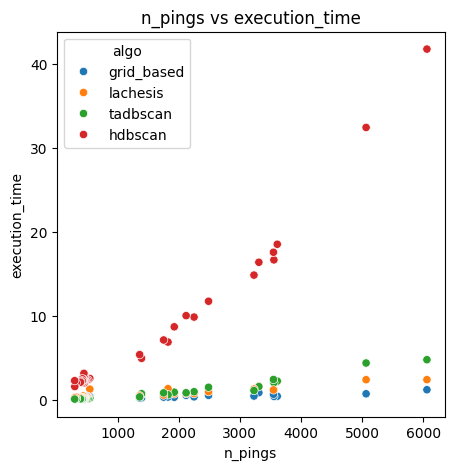

In [49]:
import seaborn as sns

algos = ['grid_based', 'lachesis', 'tadbscan', 'hdbscan']
palette = dict(zip(algos, sns.color_palette(n_colors=len(algos))))

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=metrics, x='n_pings', y='execution_time', hue='algo', ax=ax)
ax.set_title('n_pings vs execution_time')
plt.show()